##### ### The University of Melbourne, School of Computing and Information Systems
# COMP30027 Machine Learning, 2025 Semester 1

## Assignment 1: Scam detection with naive Bayes


**Student ID(s):**     `1462400`


This iPython notebook is a template which you will use for your Assignment 1 submission.

**NOTE: YOU SHOULD ADD YOUR RESULTS, GRAPHS, AND FIGURES FROM YOUR OBSERVATIONS IN THIS FILE TO YOUR REPORT (the PDF file).** Results, figures, etc. which appear in this file but are NOT included in your report will not be marked.

**Adding proper comments to your code is MANDATORY. **

Why does multinomial not really work? we are assuming that every word appearing is independent to each other- that is not true

In [419]:
import pandas as pd
from nltk.tokenize import word_tokenize
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris
from sklearn.metrics import precision_score, recall_score, accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import entropy
from scipy.sparse import csr_matrix
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt


In [331]:
# create the count matrix
def matrix(vocabulary, tokens):
    count = {}
    for word in vocabulary:
        count[word] = {}
        for i in range(len(tokens)):
            count[word][i] = tokens[i].count(word)
    return pd.DataFrame(count)

In [262]:
def matrix2(vocabulary, tokens):
    # Initialize an empty list to store the data and a dictionary for row indices
    rows = []
    cols = []
    data = []
    
    # Iterate over each word in the vocabulary
    for word_index, word in enumerate(vocabulary):
        for doc_index, doc in enumerate(tokens):
            word_count = doc.count(word)
            if word_count > 0:  # Only store non-zero counts to save space
                rows.append(doc_index)  # Row index for sparse matrix (documents)
                cols.append(word_index)  # Column index for sparse matrix (words)
                data.append(word_count)  # Value (word count in the document)

    # Create a sparse matrix (CSR format)
    sparse_matrix = csr_matrix((data, (rows, cols)), shape=(len(tokens), len(vocabulary)))

    return sparse_matrix

In [750]:
# load the dataset
training_df = pd.read_csv("sms_supervised_train.csv") 
test_df = pd.read_csv("sms_test.csv")  

# get rid of the values of preprocessed text that are NaN
training_cleaned = training_df.dropna(subset=['textPreprocessed']).reset_index(drop=True)

In [791]:
## 1. Supervised model training

# tokenise the sentences
tokens = training_cleaned['textPreprocessed'].apply(word_tokenize)

# Define vocabulary vector- every word that occurs in the dataset
vocabulary = list(set(tokens.explode().tolist()))
V = len(vocabulary)

# isolate the 'non spam' and 'spam' messages
ham_msgs = training_cleaned[training_cleaned['class'] == 0]['textPreprocessed'].reset_index(drop=True)
spam_msgs = training_cleaned[training_cleaned['class'] == 1]['textPreprocessed'].reset_index(drop=True)

# number of 'spam' and 'not spam' messages
nspam = spam_msgs.count()
nham = ham_msgs.count()

# tokenise the 'spam' and 'not spam' messages
tokens_ham = ham_msgs.apply(word_tokenize)
tokens_spam = spam_msgs.apply(word_tokenize)

# total number of 'spam' and 'not spam' words
total_spam = len(tokens_spam.sum())
total_ham = len(tokens_ham.sum())

# matrix of number of times words appear in each sentence, each spam sentence,
# and each 'not spam' sentence
count = matrix(vocabulary, tokens)
count_ham = matrix(vocabulary, tokens_ham)
count_spam = matrix(vocabulary, tokens_spam)



In [279]:
# pc,i, the probability of word i appearing in messages from class c. 
alpha = 0.1
pham = (count_ham.sum() + alpha) / (total_ham + V*alpha)
pspam = (count_spam.sum() + alpha) / (total_spam + V*alpha)
log_pham = np.log(pham)
log_pspam = np.log(pspam)

# calculate the prior probability of being a 'spam' or 'not spam' message.
priorspam = nspam / (nham + nspam)
priorham = 1 - priorspam

In [282]:
count.sum()

police        4
small         4
beer          2
page          2
lucky         9
             ..
dat           6
pop           6
colleagues    2
bother        1
1327          3
Length: 1994, dtype: int64

In [284]:
count.sum(axis=1)[]

0        3
1       19
2       25
3        4
4        9
        ..
1990     2
1991     7
1992     6
1993    17
1994    22
Length: 1995, dtype: int64

In [305]:
# 20 most likely words to appear in a 'not spam' message
pham.sort_values(ascending=False).head(20)

.       0.087429
,       0.028593
?       0.028100
u       0.020768
...     0.020584
!       0.018859
..      0.016394
;       0.014854
&       0.014361
go      0.012205
:       0.011157
get     0.010849
)       0.009063
gt      0.006413
lt      0.006352
call    0.006229
``      0.006105
#       0.005859
ok      0.005859
2       0.005797
dtype: float64

In [248]:
# 20 most likely words to appear in a 'spam' message
pspam.sort_values(ascending=False).head(20)

.           0.072766
!           0.030058
,           0.028980
call        0.025342
£           0.017124
free        0.012947
/           0.011196
2           0.010792
&           0.010657
?           0.010387
claim       0.009444
:           0.008771
*           0.008636
customer    0.008636
txt         0.008501
u           0.008232
ur          0.007962
text        0.007693
reply       0.007558
stop        0.007423
dtype: float64

In [249]:
(pspam/pham).sort_values().head(10)

gt      0.002101
lt      0.002121
ü       0.003579
lor     0.003969
hope    0.004643
d       0.005453
da      0.005740
let     0.006413
wat     0.006607
oh      0.007032
dtype: float64

In [250]:
(pspam/pham).sort_values().tail(10)

mob          286.472489
ringtone     286.472489
winner       286.472489
18           308.340618
won          330.208746
code         373.945004
paytm        395.813133
select       505.153778
tone         701.966938
prize       1095.593258
dtype: float64

In [483]:
P = np.stack([pham, pspam], axis=1)

# Compute entropy for each row (each word)
word_entropies = pd.Series(entropy(P.T, base=2))

In [990]:
vocab_df = pd.DataFrame({
    'vocabulary': vocabulary,
    'word_entropy': word_entropies.tolist(),
    'vocabulary_count': X_train.sum().tolist()
})


In [993]:
vocab_df[vocab_df['vocabulary_count'] > 100]

,vocabulary,word_entropy,vocabulary_count
146,gt,0.021674,104
283,&,0.984129,312
336,send,1.000000,102
526,?,0.841312,533
528,go,0.631410,215
581,!,0.961852,529
653,'s,0.850715,108
692,£,0.109553,131
938,just,0.996571,116
967,free,0.489862,121


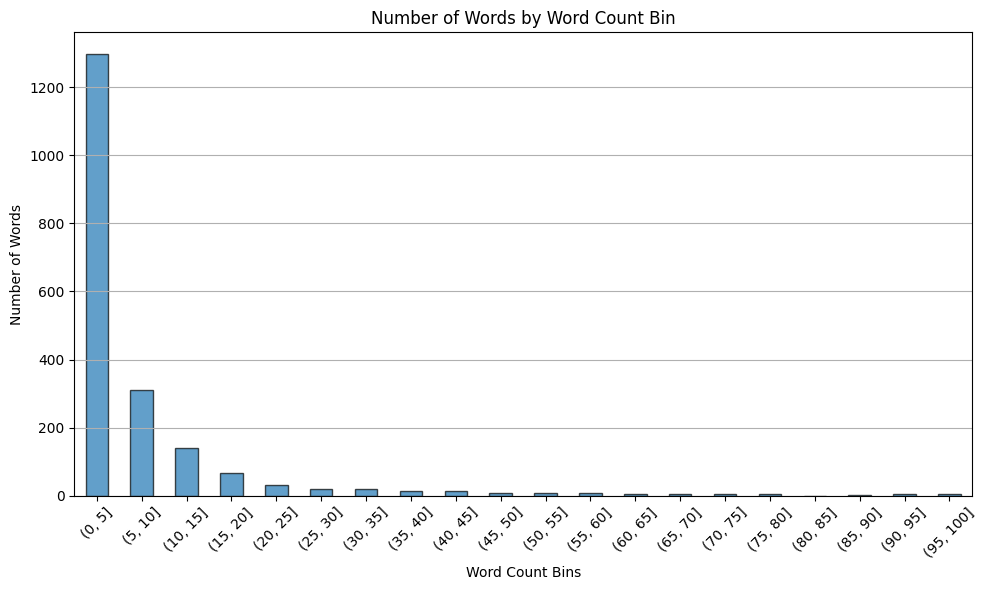

In [963]:
# Bin the vocabulary counts
bins = np.arange(0, 105, 5)  # e.g., bins of size 5 up to 100
vocab_df['count_bin'] = pd.cut(vocab_df['vocabulary_count'], bins=bins)

# Count how many words fall into each bin
bin_counts = vocab_df['count_bin'].value_counts().sort_index()

# Plot the histogram using the binned data
plt.figure(figsize=(10, 6))
bin_counts.plot(kind='bar', edgecolor='black', alpha=0.7)
plt.title("Number of Words by Word Count Bin")
plt.xlabel("Word Count Bins")
plt.ylabel("Number of Words")
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

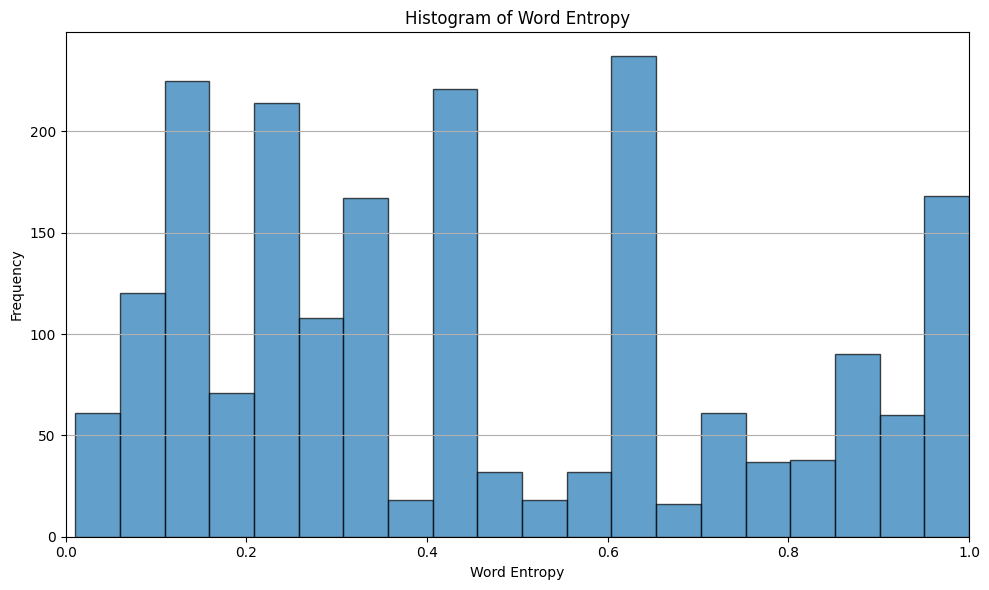

In [966]:
plt.figure(figsize=(10, 6))
plt.hist(vocab_df['word_entropy'], bins=20, edgecolor='black', alpha=0.7)
plt.title("Histogram of Word Entropy")
plt.xlabel("Word Entropy")
plt.ylabel("Frequency")
plt.xlim(0,1)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

/var/folders/c3/_dtm84vj20n8w2zkrx2cyw3w0000gp/T/ipykernel_2561/3698506682.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  count_bin_accuracy = vocab_df.groupby('count_bin')['word_entropy'].mean()


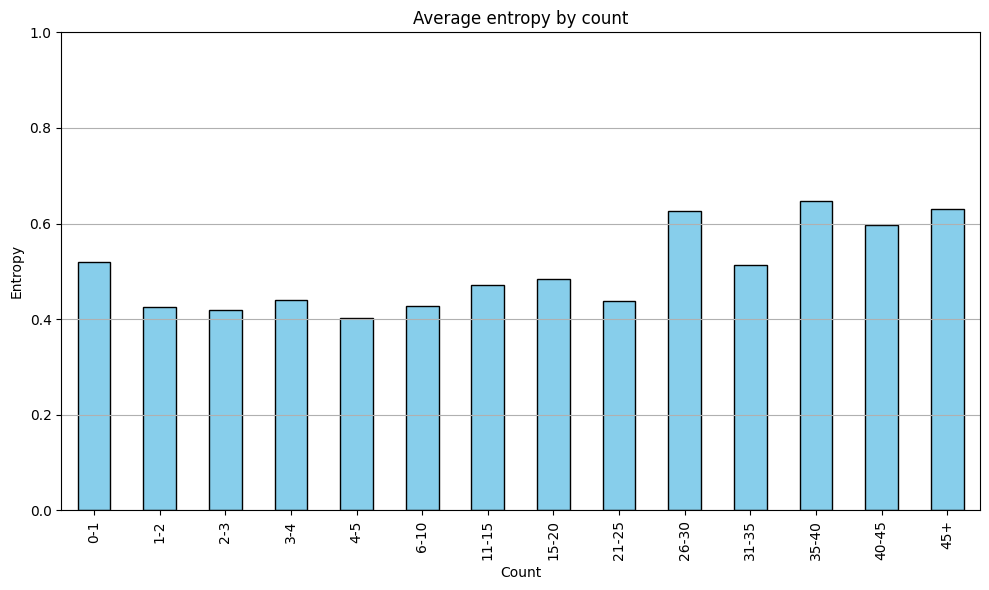

In [978]:
# Define bins for entropy
count_bin = [0, 1, 2, 3, 4, 5, 10, 15, 20, 25, 30, 35, 40, 45, float('inf')]
count_label = ['0-1', '1-2', '2-3', '3-4', '4-5', '6-10', '11-15', '15-20', '21-25', '26-30', '31-35', '35-40', '40-45', '45+']
vocab_df['count_bin'] = pd.cut(vocab_df['vocabulary_count'], bins=count_bin, labels=count_label)

# Compute average accuracy per bin
count_bin_accuracy = vocab_df.groupby('count_bin')['word_entropy'].mean()

# Plot bar graph
plt.figure(figsize=(10, 6))
count_bin_accuracy.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title("Average entropy by count")
plt.xlabel("Count")
plt.ylabel("Entropy")
plt.ylim(0, 1)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

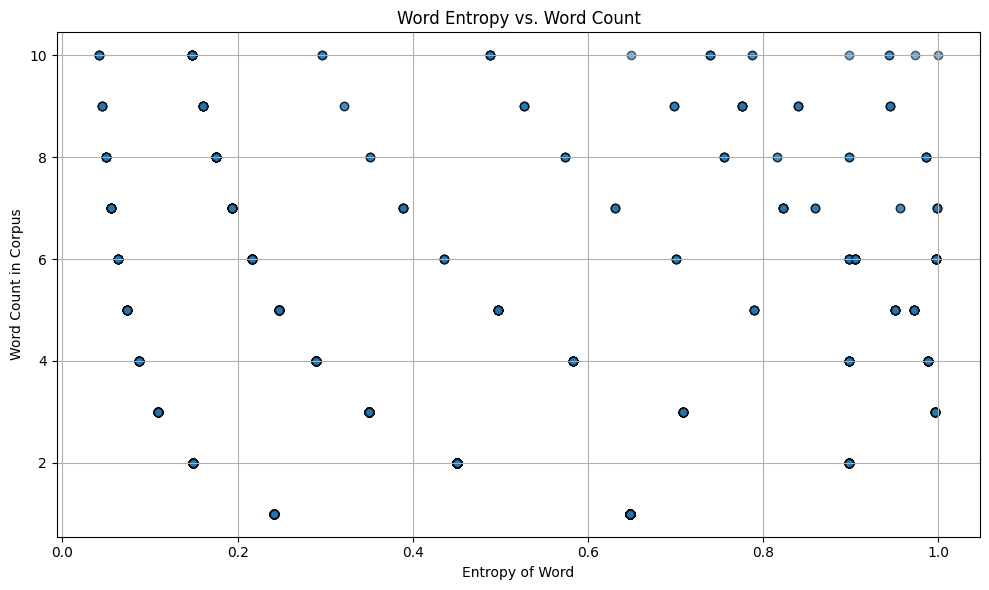

In [939]:

# Create scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(vocab_df[vocab_df['vocabulary_count'] <=10]['word_entropy'], vocab_df[vocab_df['vocabulary_count'] <=10]['vocabulary_count'], alpha=0.6, edgecolors='k')
plt.title("Word Entropy vs. Word Count")
plt.xlabel("Entropy of Word")
plt.ylabel("Word Count in Corpus")
plt.grid(True)
plt.tight_layout()
plt.show()

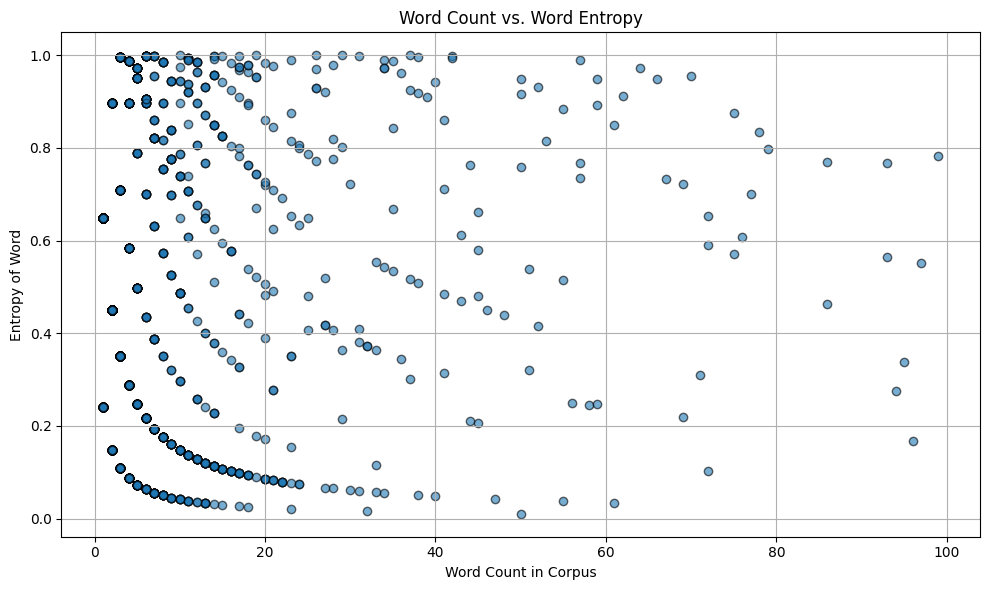

In [1054]:
# Create scatter plot with flipped axes
restrict = (vocab_df['vocabulary_count']<100)
plt.figure(figsize=(10, 6))
plt.scatter(vocab_df[restrict]['vocabulary_count'], vocab_df[restrict]['word_entropy'], alpha=0.6, edgecolors='k')
plt.title("Word Count vs. Word Entropy")
plt.xlabel("Word Count in Corpus")
plt.ylabel("Entropy of Word")
plt.grid(True)
plt.tight_layout()
plt.show()


In [1055]:
# Prepare dataset
X_train = count
y_train = df_cleaned['class']

# Split into 80% train, 20% validation (you can adjust the test_size)
X_train_new, X_val, y_train_new, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=30, stratify=y_train
)


# initialise model
val_model = MultinomialNB(alpha = 0.1)

val_model.fit(X_train_new, y_train_new)

y_val_pred = val_model.predict(X_val)

accuracy_val = accuracy_score(y_val, y_val_pred)
precision_val = precision_score(y_val, y_val_pred)  # or 'macro' / 'micro'
recall_val = recall_score(y_val, y_val_pred)

print(f"Accuracy: {accuracy_val * 100:.2f}%")
print(f"Precision: {precision_val:.2f}")
print(f"Recall: {recall_val:.2f}")

# Generate confusion matrix
cm_val = confusion_matrix(y_val, y_val_pred)

print("Confusion Matrix:")
print(cm_val)

Accuracy: 94.99%
Precision: 0.84
Recall: 0.93
Confusion Matrix:
[[305  14]
 [  6  74]]


In [1056]:
val_probs = val_model.predict_proba(X_val)
val_log_probs = val_model.predict_log_proba(X_val)

val_results = pd.DataFrame({
    'actual': y_val.values,
    'predicted': y_val_pred,
    'prob_spam': val_probs[:, 1],  # Assuming class 1 = spam
    'prob_ham': val_probs[:, 0],   # Assuming class 0 = ham
    'confidence': val_probs[:, 1] / val_probs[:, 0],
    'prob_max': np.maximum(val_probs[:, 1], val_probs[:, 0]),
    'log_prob_ham': val_log_probs[:, 0],
    'log_prob_spam': val_log_probs[:, 1],
    'log_prob_max': np.maximum(val_log_probs[:, 0], val_log_probs[:, 1]),
    'entropy': np.array([entropy(prob) for prob in val_probs])
})

val_results['accuracy'] = (val_results['actual'] == val_results['predicted']).astype(int)
val_results['word_count'] = X_val.sum(axis=1).values
word_commonality = X_train.sum()

word_commonality_masked = word_commonality.copy()
word_commonality_masked[word_commonality_masked > 100] = 0  # You can tweak 100

text_commonality = X_val.dot(word_commonality)
masked_text_commonality = X_val.dot(word_commonality_masked)
text_lengths = X_val.sum(axis=1)

avg_commonality = text_commonality / text_lengths
masked_avg_commonality = masked_text_commonality / text_lengths

val_results['avg_commonality'] = avg_commonality.reset_index(drop=True)
val_results['masked_avg_commonality'] = masked_avg_commonality.reset_index(drop=True)

val_results_misclassified = val_results[val_results['accuracy'] == 0]

/var/folders/c3/_dtm84vj20n8w2zkrx2cyw3w0000gp/T/ipykernel_2561/1599114207.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  binned_stats = val_results.groupby('commonality_bin').agg({


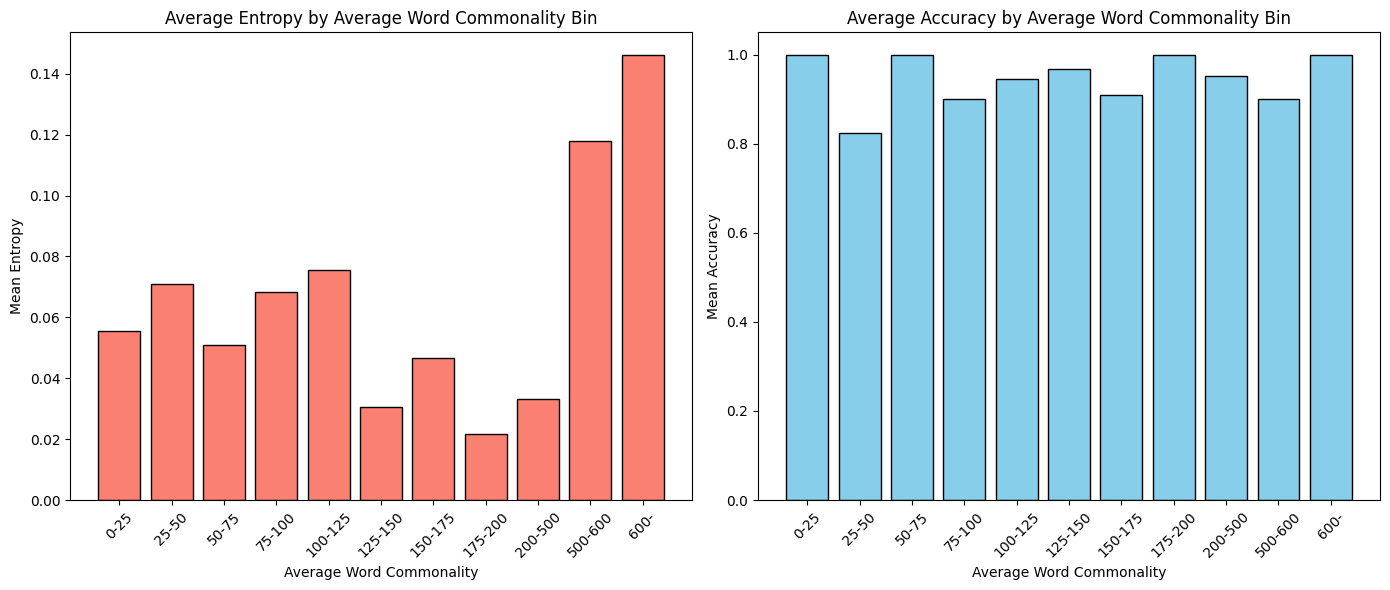

In [1057]:

# 2. Create bins (adjust as needed)
bins = [0, 25, 50, 75, 100, 125, 150, 175, 200, 500, 600, float('inf')]
labels = ['0-25', '25-50', '50-75', '75-100', '100-125', '125-150', '150-175','175-200', '200-500', '500-600', '600-']
val_results['commonality_bin'] = pd.cut(val_results['avg_commonality'], bins=bins, labels=labels)

# 3. Group by bin and compute stats
binned_stats = val_results.groupby('commonality_bin').agg({
    'entropy': 'mean',
    'accuracy': 'mean'
}).reset_index()

# 4. Plot bar graphs side-by-side
fig, axs = plt.subplots(1, 2, figsize=(14, 6), sharex=True)

# Bar graph: Entropy
axs[0].bar(binned_stats['commonality_bin'].astype(str), binned_stats['entropy'], color='salmon', edgecolor='black')
axs[0].set_title('Average Entropy by Average Word Commonality Bin')
axs[0].set_xlabel('Average Word Commonality')
axs[0].set_ylabel('Mean Entropy')
axs[0].tick_params(axis='x', rotation=45)

# Bar graph: Accuracy
axs[1].bar(binned_stats['commonality_bin'].astype(str), binned_stats['accuracy'], color='skyblue', edgecolor='black')
axs[1].set_title('Average Accuracy by Average Word Commonality Bin')
axs[1].set_xlabel('Average Word Commonality')
axs[1].set_ylabel('Mean Accuracy')
axs[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


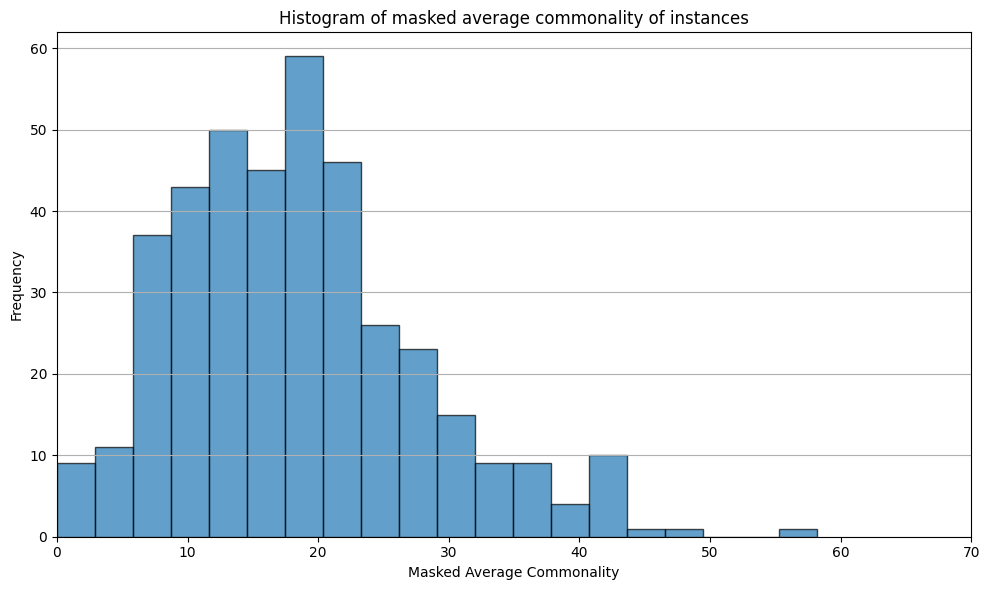

In [1049]:
plt.figure(figsize=(10, 6))
plt.hist(val_results['masked_avg_commonality'], bins=20, edgecolor='black', alpha=0.7)
plt.title("Histogram of masked average commonality of instances")
plt.xlabel("Masked Average Commonality")
plt.ylabel("Frequency")
plt.xlim(0,70)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

/var/folders/c3/_dtm84vj20n8w2zkrx2cyw3w0000gp/T/ipykernel_2561/2901830057.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  binned_stats = val_results.groupby('masked_commonality_bin').agg({


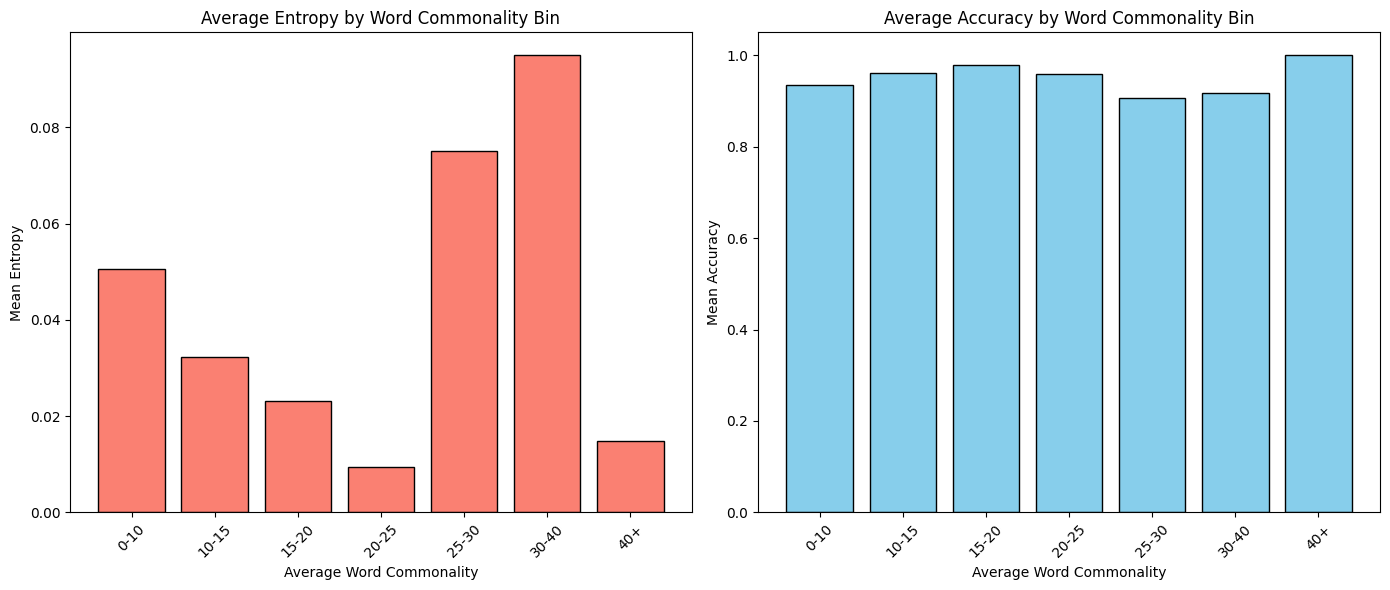

In [1050]:

# 2. Create bins (adjust as needed)
bins = [0,10, 15, 20, 25, 35, 40, float('inf')]
labels = ['0-10', '10-15' ,'15-20' , '20-25','25-30', '30-40', '40+']
val_results['masked_commonality_bin'] = pd.cut(val_results['masked_avg_commonality'], bins=bins, labels=labels)

# 3. Group by bin and compute stats
binned_stats = val_results.groupby('masked_commonality_bin').agg({
    'entropy': 'mean',
    'accuracy': 'mean'
}).reset_index()

# 4. Plot bar graphs side-by-side
fig, axs = plt.subplots(1, 2, figsize=(14, 6), sharex=True)

# Bar graph: Entropy
axs[0].bar(binned_stats['masked_commonality_bin'].astype(str), binned_stats['entropy'], color='salmon', edgecolor='black')
axs[0].set_title('Average Entropy by Word Commonality Bin')
axs[0].set_xlabel('Average Word Commonality')
axs[0].set_ylabel('Mean Entropy')
axs[0].tick_params(axis='x', rotation=45)

# Bar graph: Accuracy
axs[1].bar(binned_stats['masked_commonality_bin'].astype(str), binned_stats['accuracy'], color='skyblue', edgecolor='black')
axs[1].set_title('Average Accuracy by Word Commonality Bin')
axs[1].set_xlabel('Average Word Commonality')
axs[1].set_ylabel('Mean Accuracy')
axs[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


In [1052]:
val_results[(val_results['masked_avg_commonality']>30) & (val_results['masked_avg_commonality']<40)]

,actual,predicted,prob_spam,prob_ham,confidence,prob_max,log_prob_ham,log_prob_spam,log_prob_max,entropy,accuracy,word_count,avg_commonality,masked_avg_commonality,commonality_bin,masked_commonality_bin
0,0,0,1.595247e-04,9.998405e-01,1.595501e-04,0.999840,-1.595374e-04,-8.743312e+00,-1.595374e-04,1.554286e-03,1,7,315.571429,35.714286,200-500,30-40
19,0,0,1.367837e-07,9.999999e-01,1.367837e-07,1.000000,-1.367837e-07,-1.580487e+01,-1.367837e-07,2.298631e-06,1,6,121.500000,32.666667,100-125,25-30
20,0,0,4.594010e-03,9.954060e-01,4.615212e-03,0.995406,-4.604595e-03,-5.383002e+00,-4.604595e-03,2.931301e-02,1,4,163.000000,30.750000,150-175,25-30
48,0,0,2.993263e-12,1.000000e+00,2.993263e-12,1.000000,-2.998490e-12,-2.653466e+01,-2.998490e-12,8.241848e-11,1,12,166.000000,32.416667,150-175,25-30
50,0,0,5.590763e-08,9.999999e-01,5.590764e-08,1.000000,-5.590763e-08,-1.669956e+01,-5.590763e-08,9.895408e-07,1,9,195.222222,31.777778,175-200,25-30
65,0,0,1.086124e-06,9.999989e-01,1.086125e-06,0.999999,-1.086125e-06,-1.373290e+01,-1.086125e-06,1.600175e-05,1,14,195.571429,35.785714,175-200,30-40
87,0,0,5.670110e-08,9.999999e-01,5.670110e-08,1.000000,-5.670110e-08,-1.668547e+01,-5.670110e-08,1.002786e-06,1,6,408.500000,35.666667,200-500,30-40
114,0,0,9.783982e-11,1.000000e+00,9.783982e-11,1.000000,-9.784173e-11,-2.304769e+01,-9.784173e-11,2.352822e-09,1,17,507.764706,31.117647,500-600,25-30
123,0,0,1.886159e-08,1.000000e+00,1.886159e-08,1.000000,-1.886159e-08,-1.778614e+01,-1.886159e-08,3.543364e-07,1,4,103.250000,33.750000,100-125,25-30
127,0,0,1.645782e-04,9.998354e-01,1.646053e-04,0.999835,-1.645917e-04,-8.712125e+00,-1.645917e-04,1.598390e-03,1,5,217.600000,31.400000,200-500,25-30


/var/folders/c3/_dtm84vj20n8w2zkrx2cyw3w0000gp/T/ipykernel_2561/953023192.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  entropy_bin_accuracy = val_results.groupby('entropy_bin')['accuracy'].mean()


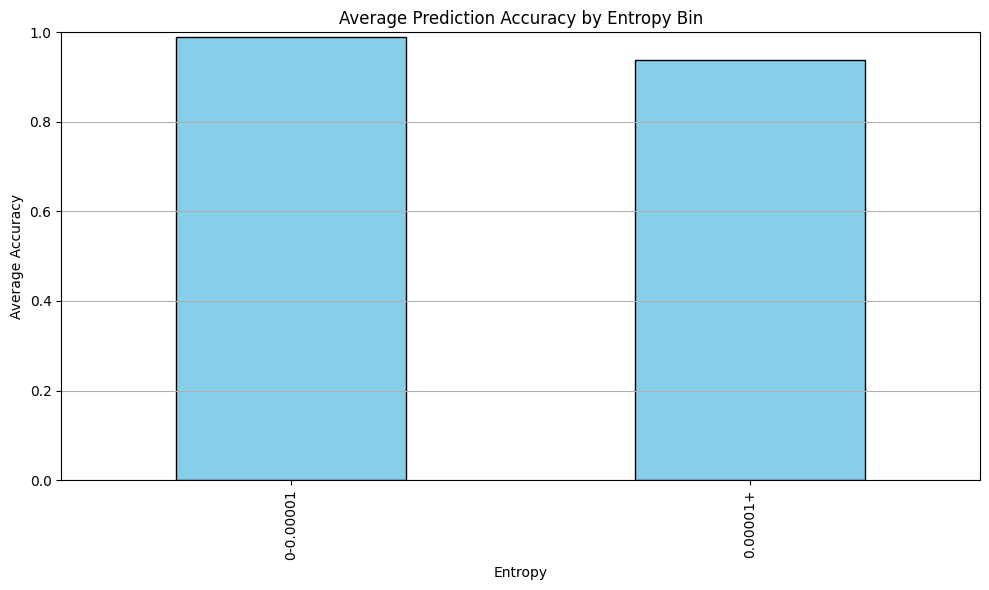

In [979]:
# Define bins for entropy
entropy_bins = [0, 0.00001, float('inf')]
entropy_labels = ['0-0.00001', '0.00001+']
val_results['entropy_bin'] = pd.cut(val_results['entropy'], bins=entropy_bins, labels=entropy_labels)

# Compute average accuracy per bin
entropy_bin_accuracy = val_results.groupby('entropy_bin')['accuracy'].mean()

# Plot bar graph
plt.figure(figsize=(10, 6))
entropy_bin_accuracy.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title("Average Prediction Accuracy by Entropy Bin")
plt.xlabel("Entropy")
plt.ylabel("Average Accuracy")
plt.ylim(0, 1)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

In [571]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Prepare the data: X is entropy, y is accuracy
X_entropy = val_results[['entropy']]  # Feature (entropy)
X_entropy = sm.add_constant(X_entropy)  # Add a constant (intercept) to the model
y_accuracy = val_results['accuracy']  # Target (misclassification: 0 or 1)

# Fit the linear regression model using statsmodels
reg_model = sm.OLS(y_accuracy, X_entropy).fit()

# Get the model summary (coefficients, t-statistics, p-values, etc.)
print(reg_model.summary())


                            OLS Regression Results                            
Dep. Variable:               accuracy   R-squared:                       0.218
Model:                            OLS   Adj. R-squared:                  0.216
Method:                 Least Squares   F-statistic:                     110.4
Date:                Fri, 11 Apr 2025   Prob (F-statistic):           6.07e-23
Time:                        12:08:44   Log-Likelihood:                 144.97
No. Observations:                 399   AIC:                            -285.9
Df Residuals:                     397   BIC:                            -278.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.9957      0.009    110.395      0.0

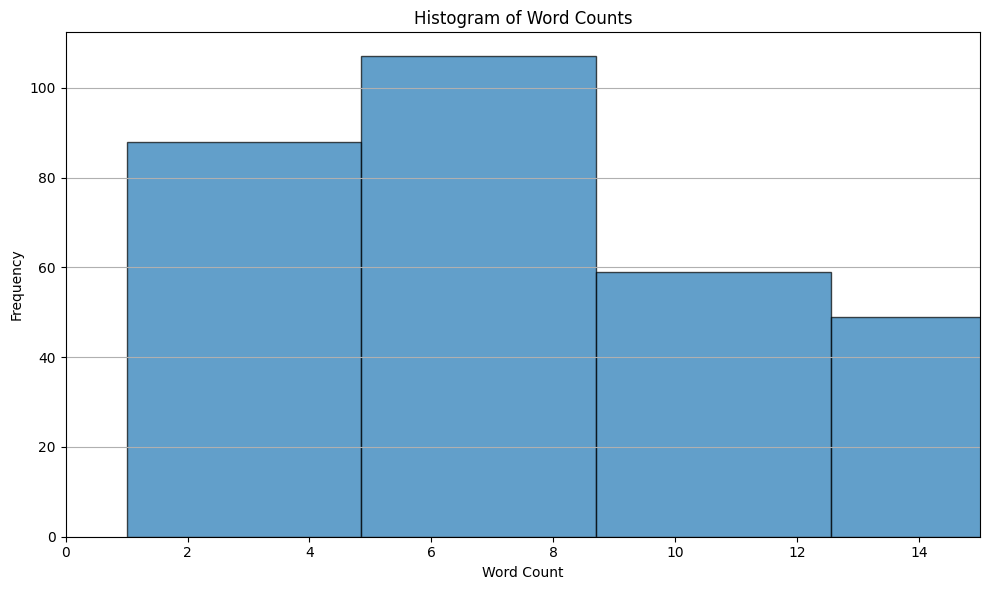

In [574]:
plt.figure(figsize=(10, 6))
plt.hist(val_results['word_count'], bins=20, edgecolor='black', alpha=0.7)
plt.title("Histogram of Word Counts")
plt.xlabel("Word Count")
plt.ylabel("Frequency")
plt.xlim(0,15)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

/var/folders/c3/_dtm84vj20n8w2zkrx2cyw3w0000gp/T/ipykernel_2561/1800727457.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  word_count_bin_accuracy = val_results.groupby('word_count_bins')['accuracy'].mean()


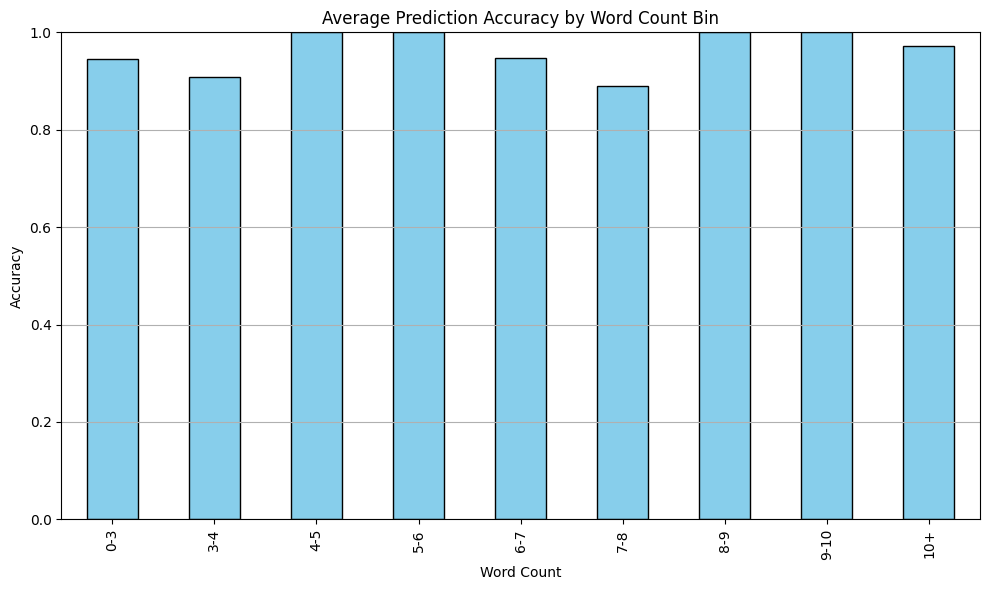

In [575]:
# Define bins for word count
word_count_bins = [0,3,4, 5, 6, 7, 8, 9, 10, 100]
word_count_labels = ['0-3', '3-4', '4-5', '5-6', '6-7', '7-8', '8-9', '9-10', '10+']
val_results['word_count_bins'] = pd.cut(val_results['word_count'], bins=word_count_bins, labels=word_count_labels)

word_count_bin_accuracy = val_results.groupby('word_count_bins')['accuracy'].mean()
# Plot bar graph
plt.figure(figsize=(10, 6))
word_count_bin_accuracy.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title("Average Prediction Accuracy by Word Count Bin")
plt.xlabel("Word Count")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

/var/folders/c3/_dtm84vj20n8w2zkrx2cyw3w0000gp/T/ipykernel_2561/1165107486.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  quantile_accuracy = val_results.groupby('word_count_quantile_bin')['accuracy'].mean()


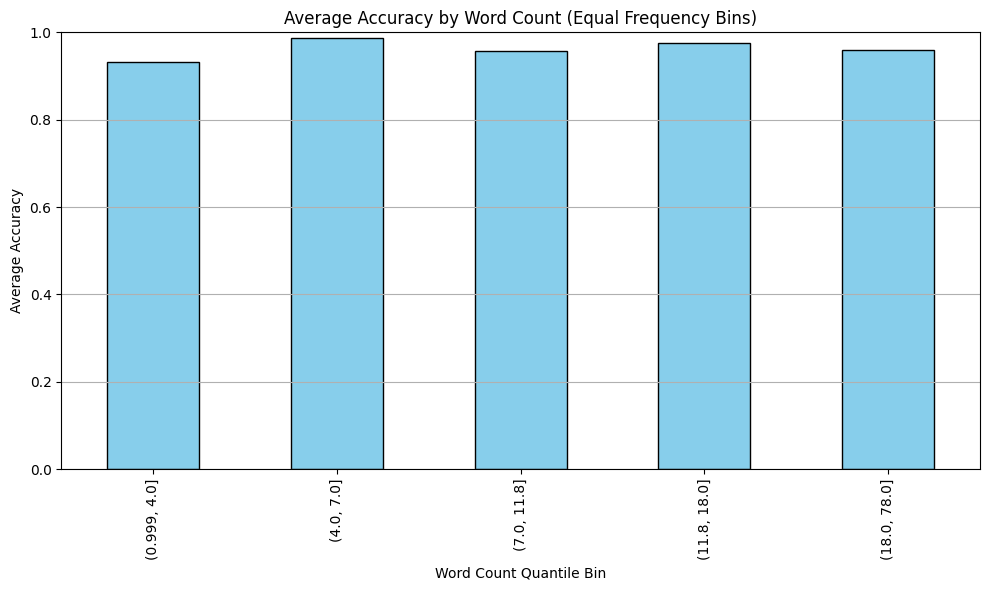

In [576]:
# Create quantile-based bins for word count (e.g., 5 equal-frequency bins)
val_results['word_count_quantile_bin'] = pd.qcut(val_results['word_count'], q=5)

# Compute average accuracy per quantile bin
quantile_accuracy = val_results.groupby('word_count_quantile_bin')['accuracy'].mean()

# Plot
plt.figure(figsize=(10, 6))
quantile_accuracy.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title("Average Accuracy by Word Count (Equal Frequency Bins)")
plt.xlabel("Word Count Quantile Bin")
plt.ylabel("Average Accuracy")
plt.ylim(0, 1)
plt.grid(axis='y')
plt.tight_layout()
plt.show()


In [604]:
val_results["commonality"] = X_val.dot(word_commonality).reset_index(drop=True)

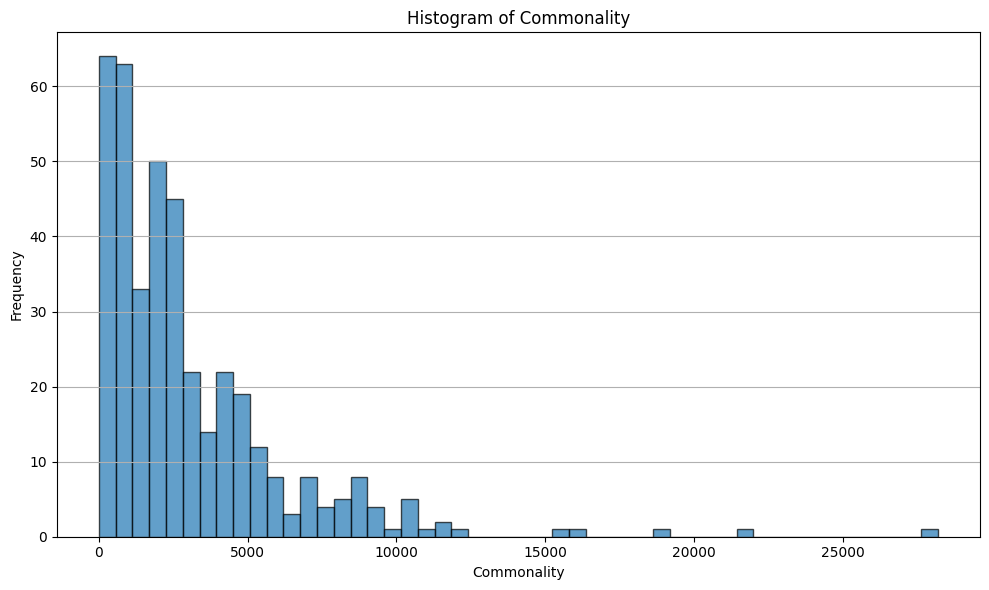

In [607]:
plt.figure(figsize=(10, 6))
plt.hist(val_results['commonality'], bins=50, edgecolor='black', alpha=0.7)
plt.title("Histogram of Commonality")
plt.xlabel("Commonality")
plt.ylabel("Frequency")
plt.grid(axis='y')
plt.tight_layout()
plt.show()

In [986]:
len(val_results_misclassified[val_results_misclassified["entropy"]<0.1])/len(val_results_misclassified)

0.4

## 2. Supervised model evaluation


Out of vocabulary words- words that did not appear our training set. We can easily check this by checking if each word is part of our vocabulary vector. Question is, can we just get rid of all words that are not part of vocabulary?- yes, then we can get rid of nan?

Okay- is it alright to mess up the series like that? We will have a shorted series- what do we do with these tokens again?


We will have a series of tokens, this will make up our X test? We will convert each sentence into a vector, from there, calculate the probability of each one occuring

In [62]:
# We first want to clear all the words that we don't have in place.

# Tokenise our messages
test_tokens = test_df['textPreprocessed'].apply(word_tokenize)
test_df['textFiltered'] = test_tokens.apply(lambda s: [w for w in s if w in vocabulary] or np.nan)
test_filtered = test.dropna(subset=['textFiltered']).reset_index(drop=True)


In [741]:
# prepare dataset
X_test = matrix(vocabulary, test_filtered["textFiltered"])
y_test = test_filtered['class']

# initialise model
model = MultinomialNB(alpha = 0.1)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)  # or 'macro' / 'micro'
recall = recall_score(y_test, y_pred)

print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

print("Confusion Matrix:")
print(cm)

Accuracy: 97.00%
Precision: 0.93
Recall: 0.93
Confusion Matrix:
[[785  15]
 [ 15 185]]


In [743]:
# Posterior probabilities (P(class | features))
probs = model.predict_proba(X_test)
log_posteriors = model.predict_log_proba(X_test)

# Create a DataFrame with predictions and ground truth
test_results = pd.DataFrame({
    'actual': y_test.values,
    'predicted': y_pred,
    'prob_spam': probs[:, 1],  # Assuming class 1 = spam
    'prob_ham': probs[:, 0],   # Assuming class 0 = ham
    'confidence': probs[:, 1] / probs[:, 0],
    'max_prob': np.maximum(probs[:, 1], probs[:, 0]),
    'log_posterior_ham': log_posteriors[:, 0],
    'log_posterior_spam': log_posteriors[:, 1],
    'max_log_posterior': np.maximum(log_posteriors[:, 0], log_posteriors[:, 1])
})
# Add text back for context (optional, but helpful)
results['text'] = test_filtered.loc[y_test.index, 'textPreprocessed'].values
results['original'] = test_filtered.loc[y_test.index, 'textOriginal'].values

misclassified_df = test_results[y_pred != y_test.values]

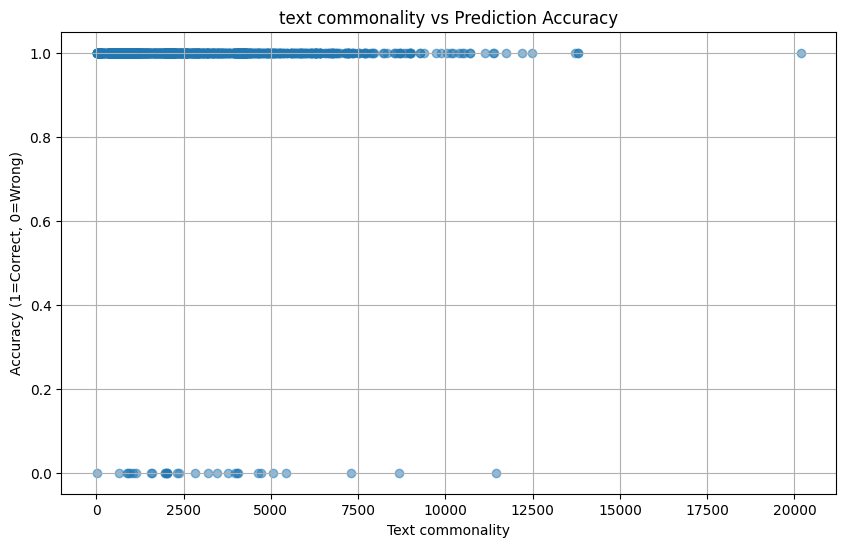

In [166]:
# Plot word count vs prediction accuracy
plt.figure(figsize=(10, 6))
plt.scatter(X_test.dot(count.sum()), accuracy, alpha=0.5)
plt.title("text commonality vs Prediction Accuracy")
plt.xlabel("Text commonality")
plt.ylabel("Accuracy (1=Correct, 0=Wrong)")
plt.grid(True)
plt.show()

/var/folders/c3/_dtm84vj20n8w2zkrx2cyw3w0000gp/T/ipykernel_2561/1162066963.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_accuracy = df_plot.groupby('Length_Bin')['Accuracy'].mean()


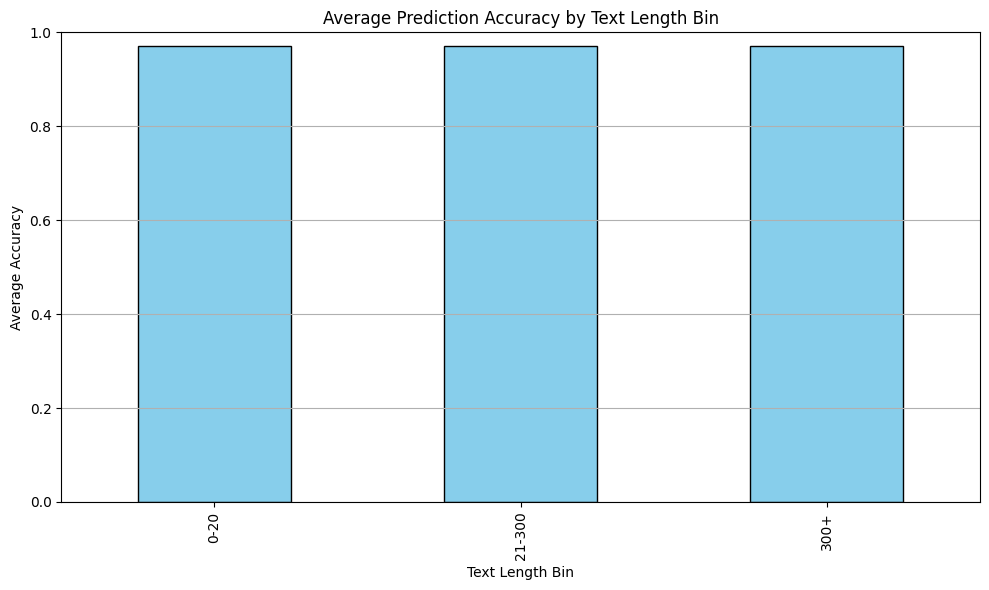

In [742]:
# Compute total word count per text

# Create a DataFrame with word count and accuracy
df_plot = pd.DataFrame({
    'Text_Length': X_test.dot(count.sum(axis=0)),
    'Accuracy': accuracy  # Series of 0 (wrong) or 1 (correct)
})

# Define bins for word counts
bins = [0, 20, 300, float('inf')]
labels = ['0-20', '21-300', '300+']
df_plot['Length_Bin'] = pd.cut(df_plot['Text_Length'], bins=bins, labels=labels)

# Compute average accuracy per bin
bin_accuracy = df_plot.groupby('Length_Bin')['Accuracy'].mean()

# Plot bar graph
plt.figure(figsize=(10, 6))
bin_accuracy.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title("Average Prediction Accuracy by Text Length Bin")
plt.xlabel("Text Length Bin")
plt.ylabel("Average Accuracy")
plt.ylim(0, 1)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

## 3. Extending the model with semi-supervised training

IDEA 1: just take the most common unseen words in the new data
IDEA 2: take the least common seen words in the training data
IDEA 3: take the texts that are the most wrong, by extension, words from the texts that are most wrong
IDEA 4: use where the training data is the most wrong

In [745]:
unlabelled_df = pd.read_csv("sms_unlabelled.csv") 
unlabelled_df[unlabelled_df['textPreprocessed'].isna()]

In [753]:
unlabelled_cleaned = unlabelled_df.dropna(subset=['textPreprocessed']).reset_index(drop=True)
unlabelled_cleaned

,textOriginal,textPreprocessed,class
0,Your opinion about me? 1. Over 2. Jada 3. Kusr...,opinion ? 1 . . . . . . . . . 2 3 4 lovable 5 ...,0
1,Please Stay At Home. To encourage the notion o...,. . . � home home please stay stay citizen ent...,1
2,BankOfAmerica Alert 137943. Please follow http...,. please alert follow re-activate,1
3,Sorry dude. Dont know how i forgot. Even after...,. . . . . sorry sorry dude know forget even re...,0
4,No. I dont want to hear anything,. hear anything,0
...,...,...,...
1987,Kay... Since we are out already,already ...,0
1988,call now 08707509020 Just 20p per min NTT Ltd...,", call call just rate national per 0870 min 08...",1
1989,Are you angry with me. What happen dear,. angry dear happen,0
1990,We r outside already.,. already r outside,0


In [823]:
unlabelled_tokens = unlabelled_cleaned['textPreprocessed'].apply(word_tokenize)
unlabelled_cleaned['textFiltered'] = unlabelled_tokens.apply(lambda s: [w for w in s if w in vocabulary] or np.nan)
unlabelled_filtered = test.dropna(subset=['textFiltered']).reset_index(drop=True)
unlabelled_count = matrix(vocabulary, unlabelled_tokens)
unlabelled_vocabulary = list(set(unlabelled_tokens.explode().tolist()))
extended_vocabulary = list(set(vocabulary).union(set(unlabelled_vocabulary)))
unlabelled_count_extended = matrix(extended_vocabulary, unlabelled_tokens)
unlabelled_out_of_vocab = list(set(unlabelled_vocabulary) - set(vocabulary))

In [824]:
unlabelled_count

,police,small,beer,page,lucky,gurgaon,6th,lei,xxxx,worry,...,course,princess,setting,advise,09065174042,dat,pop,colleagues,bother,1327
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1987,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1988,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1989,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1990,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [825]:
unlabelled_count_extended

,police,small,beer,page,gurgaon,lucky,6th,lei,xxxx,worry,...,princess,setting,advise,09065174042,dat,pop,colleagues,bother,fetch,usf
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1987,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1988,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1989,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1990,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [832]:
out_of_vocab_count = unlabelled_count_extended[unlabelled_out_of_vocab]

In [ ]:
# IDEA 1- JUST TAKE THE HIGHEST ENTROPY OPTIONS AND TRAIN IT IN
# PROBABLY FILTER FOR HIGH ENTROPY AND GOOD WORD COMMONALITY

In [840]:
# Count how many instances each OOV word appears in
oov_word_instance_counts = (out_of_vocab_count > 0).sum(axis=0)
oov_word_instance_counts[oov_word_instance_counts > 3]

experience      4
basic           5
yijue           5
piece           4
possession      4
brain           4
perfect         4
nvm             4
88039           4
lift            5
din             4
cruise          4
require         4
ma              4
=d              4
lmao            5
depend          5
clock           5
affair          4
bahamas         4
realy           4
trouble         4
scared          4
08081560665     4
definitely      4
august          5
wed             4
callfreefone    4
business        4
skilgme         4
activity        4
greet           4
fetch           4
dtype: int64

## 4. Supervised model evaluation